# Web Scraping Using BeautifulSoup

## Importing the libraries

In [24]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests

# Removing row limits from pandas
pd.set_option('display.max_rows', None)

## Loading the initial page

In [2]:
# Load the page content
url = 'https://www.skinnytaste.com/recipe-index/?_paged=1'
page = requests.get(url)

# Check status
if page.status_code == 200:
  print('Page loaded')
elif page.status_code == 404:
  print('Not found')

print(page.url)
print(page.headers)

# Convert into a BeautifulSoup object
soup = bs(page.content, 'html.parser')

Page loaded
https://www.skinnytaste.com/recipe-index/?_paged=1
{'Date': 'Sun, 22 Sep 2024 07:42:24 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'vary': 'Accept-Encoding', 'Cache-Control': 'no-store, no-cache, must-revalidate, max-age=0', 'pragma': 'no-cache', 'expires': 'Sun, 22 Sep 2024 07:42:24 GMT', 'x-bigscoots-cache': 'no-cache', 'x-bigscoots-cache-control': 'no-store, no-cache, must-revalidate, max-age=0', 'x-bigscoots-cache-plan': 'Standard', 'link': '<https://www.skinnytaste.com/wp-json/>; rel="https://api.w.org/", <https://www.skinnytaste.com/wp-json/wp/v2/pages/21165>; rel="alternate"; title="JSON"; type="application/json", <https://www.skinnytaste.com/?p=21165>; rel=shortlink', 'x-wordlift-includeexclude-stage-0': 'Filter Called with default include', 'x-wordlift-includeexclude-stage-1': 'Condition Matched for https://www.skinnytaste.com/recipe-index/', 'x-wordlift-includeexclude-note': 'To bypass the Include/E

## Scraping the first page and finding the needed information

In [3]:
from ast import Continue

# Looking for urls and titles
recipes = soup.find_all('h2')

# First thing in the list is a promotional offer, have to ignore it
print(recipes[0].find('a').text)
print(recipes[1].find('a').text)

# Looping through the list to extract information
for recipe in recipes[1:20]:
  recipe_url = recipe.find('a')['href']
  recipe_soup = bs(requests.get(recipe_url).text, 'html.parser')
  # Skipping titles where it's a collection of recipes, rather than a single recipe
  title = recipe_soup.find('h1', class_='entry-title').text
  if title and not title[0].isdigit() and not '+' in title:
    valid_title = title
  else:
    continue

  # Extracting first the figure, then image information
  figure = recipe_soup.find('figure', class_='wp-block-image size-full')
  image = figure.find('img')['src']

  # Calories consists of label and the value, extracting just the value
  calories = recipe_soup.find('span', class_='recipe-meta-value value-calories').text.split()[1]
  points = recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon').text
  summary = recipe_soup.find('p').text

  # Find all <ul> elements in the recipe keys section
  recipe_keys_section = recipe_soup.find_all('ul', class_='cat-icons post-icons')

  # Initialize an empty list to store the keys
  recipe_keys_list = []

  # Loop through each <ul> element
  for section in recipe_keys_section:
    keys = section.find_all('li')

    #Extract the text from each <li> and add it to the list
    for key in keys:
      a_tag = key.find('a')
      if a_tag:
        recipe_key_text = a_tag['title']
        recipe_keys_list.append(recipe_key_text)
  print(f'{valid_title}, {image}, {calories}, {points}, {summary}, {recipe_keys_list}')

Free 7 Day Healthy Meal Plan (Sept 23-29)
Apple Butter
Apple Butter, https://www.skinnytaste.com/wp-content/uploads/2024/09/Apple-Butter-6.jpg, 34, 1, This easy apple butter recipe simmers on the stove, made with apples, cinnamon, nutmeg, and allspice, it smells and tastes like fall!, ['Dairy Free Recipes', 'Gluten Free', 'Kid Friendly', 'Vegetarian Meals']
Roasted Delicata Squash, https://www.skinnytaste.com/wp-content/uploads/2024/09/Roasted-Delicata-Squash-with-Toasted-Almond-Crumbs-9.jpg, 177, 4, Roasted Delicata Squash with toasted almonds, sweetened with maple syrup and seasoned with sage and paprika, makes a perfect fall side dish., ['Dairy Free Recipes', 'Gluten Free', 'Vegetarian Meals']
Apple Bread, https://www.skinnytaste.com/wp-content/uploads/2014/09/Apple-Bread-3.jpg, 124, 4, Moist cinnamon apple bread recipe made with applesauce, small chunks of fresh apples and walnuts in every bite. It’s so moist and delicious, you won’t believe it’s light!, ['Vegetarian Meals']
Autumn

## Getting information from 50 pages

In [5]:
recipe_names = []
recipe_images = []
recipe_calories = []
recipe_points = []
recipe_summaries = []
recipe_keys = []

for i in range(1, 51):
  url = f'https://www.skinnytaste.com/recipe-index/?_paged={i}'
  soup = bs(requests.get(url).text, 'html.parser')
  all_recipes = soup.find_all('h2')

  # Looping through the list to extract information. Adding additional logic to skip the promotional offer.
  if i == 1:
    recipes_to_scrape = all_recipes[1:20]
  else:
    recipes_to_scrape = all_recipes[:20]

  # Looping through the selected list of elements
  for recipe in recipes_to_scrape:
    recipe_url = recipe.find('a')['href']

  # Converting the recipe to a BeautifulSoup object
    recipe_soup = bs(requests.get(recipe_url).text, 'html.parser')

    # Checking if the recipe has points, to make sure it's a recipe and not a promotion or a collection
    points_tag = recipe_soup.find('span', class_='recipe-meta-value recipe-ww-pp icon')
    if points_tag:
      valid_points = points_tag.text
    else:
      continue

    title = recipe_soup.find('h1', class_='entry-title').text

    # Extracting first the figure, then image information
    figure = recipe_soup.find('figure', class_='wp-block-image size-full')
    if figure:
      image = figure.find('img')['src']
    else:
      valid_figure = recipe_soup.find('div', class_='dpsp-pin-it-wrapper alignnone size-full wp-image-26771')
      if valid_figure:
        image = valid_figure.find('img')['src']
      else:
        image = 'No picture available'

    # Calories consists of label and the value, extracting just the value
    calories = recipe_soup.find('span', class_='recipe-meta-value value-calories').text.split()[1]
    summary = recipe_soup.find('p').text

    # Find all <ul> elements in the recipe keys section
    recipe_keys_section = recipe_soup.find_all('ul', class_='cat-icons post-icons')

    # Initialize an empty list to store the keys
    current_recipe_keys = []

    # Loop through each <ul> element
    for section in recipe_keys_section:
      keys = section.find_all('li')

      #Extract the <a> from each <li>, extract title from a_tag and add it to the list
      for key in keys:
        a_tag = key.find('a')
        if a_tag:
          recipe_key_text = a_tag['title']
          current_recipe_keys.append(recipe_key_text)
    recipe_names.append(title)
    recipe_images.append(image)
    recipe_calories.append(float(calories))
    recipe_points.append(int(valid_points))
    recipe_summaries.append(summary)
    recipe_keys.append(current_recipe_keys)

KeyboardInterrupt: 

## Putting the information in a DataFrame

In [6]:
import pandas as pd

recipes_df = pd.DataFrame({'Title': recipe_names, 'Image': recipe_images,
                           'Calories': recipe_calories, 'Points': recipe_points,
                           'Summary': recipe_summaries, 'Keys': recipe_keys
                           })
# Setting the index to start from 1
recipes_df.index = recipes_df.index + 1

recipes_df.head(10)

,Title,Image,Calories,Points,Summary,Keys
1,Apple Butter,https://www.skinnytaste.com/wp-content/uploads...,34.0,1,This easy apple butter recipe simmers on the s...,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."
2,Roasted Delicata Squash,https://www.skinnytaste.com/wp-content/uploads...,177.0,4,"Roasted Delicata Squash with toasted almonds, ...","[Dairy Free Recipes, Gluten Free, Vegetarian M..."
3,Apple Bread,https://www.skinnytaste.com/wp-content/uploads...,124.0,4,Moist cinnamon apple bread recipe made with ap...,[Vegetarian Meals]
4,Autumn Salad with Pears and Gorgonzola,https://www.skinnytaste.com/wp-content/uploads...,175.0,5,I love a good salad with lots of texture and f...,"[Gluten Free, Low Carb, Under 30 Minutes, Vege..."
5,Sesame Chicken,https://www.skinnytaste.com/wp-content/uploads...,513.0,9,This lighter Sesame Chicken recipe features ch...,"[Dairy Free Recipes, Freezer Meals, Gluten Fre..."
6,Bacon in the Oven,https://www.skinnytaste.com/wp-content/uploads...,60.0,2,"Whether you’re a fan of tender, crisp, or extr...","[Dairy Free Recipes, Gluten Free, High Protein..."
7,Pumpkin Spice Latte,https://www.skinnytaste.com/wp-content/uploads...,115.0,7,Embrace all the cozy fall vibes with a homemad...,"[Dairy Free Recipes, Gluten Free, Vegetarian M..."
8,Homemade Hamburger Helper,https://www.skinnytaste.com/wp-content/uploads...,453.0,12,"This one-skillet, creamy Homemade Hamburger He...","[Dairy Free Recipes, Gluten Free, High Protein..."
9,Fried Brown Rice,https://www.skinnytaste.com/wp-content/uploads...,276.0,6,Fried Brown Rice is a healthy twist on classic...,"[Dairy Free Recipes, Gluten Free, High-Fiber R..."
10,Asian Grilled Chicken,https://www.skinnytaste.com/wp-content/uploads...,288.5,4,This Asian Grilled Chicken recipe is the perfe...,"[Dairy Free Recipes, Gluten Free, Kid Friendly..."


## EDA and Visualization

### Distribution of Calories

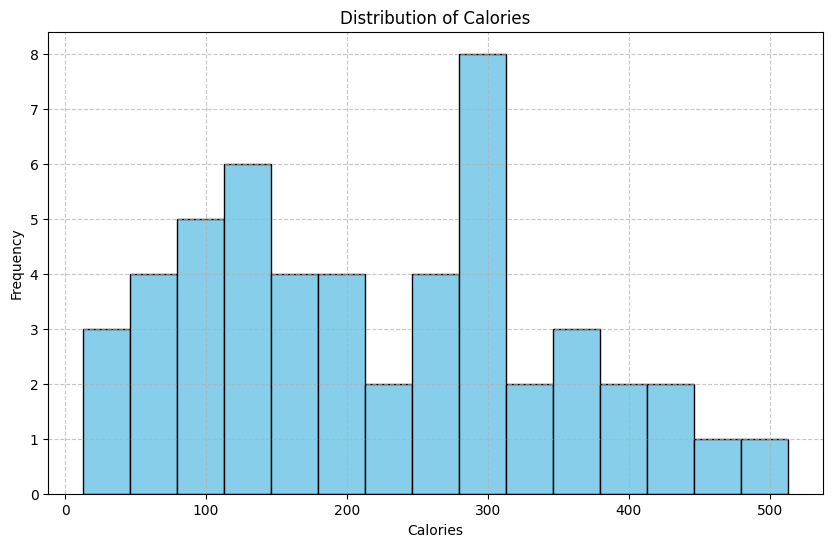

In [7]:
# Dropping any missing values
recipes_df = recipes_df.dropna(subset=['Calories'])

# Plotting the histogram
plt.figure(figsize=(10,6))
recipes_df['Calories'].hist(bins=15, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Distribution of Calories')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

### Distribution of Recipe Keys

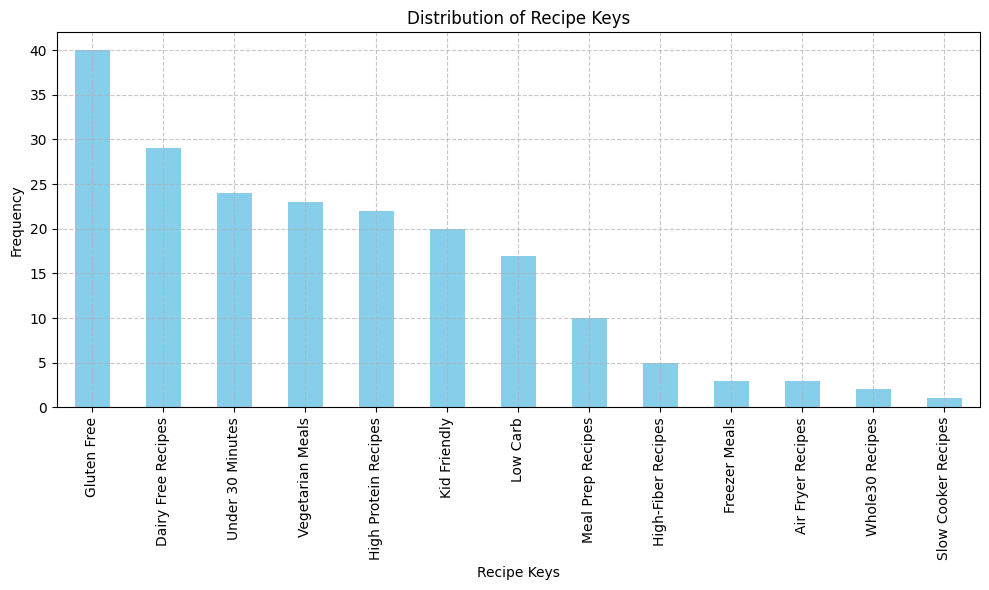

In [8]:
# Exploding the keys column to get one recipe key per row
exploded_keys = recipes_df.explode('Keys')

# Counting the occurrences
key_counts = exploded_keys['Keys'].value_counts()

# Plotting the distribution as a bar chart
plt.figure(figsize=(10, 6))
key_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Distribution of Recipe Keys')
plt.xlabel('Recipe Keys')
plt.ylabel('Frequency')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent clipping of labels

plt.show()

### Points distribution

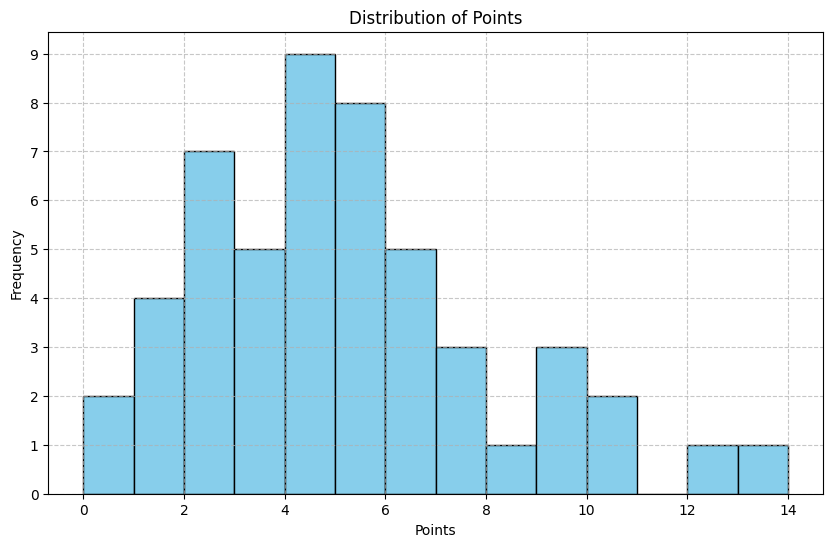

In [9]:
# Converting points to integer type
recipes_df['Points'] = recipes_df['Points'].astype(int)

# Defining bins to align with integer points
max_points = recipes_df['Points'].max()
min_points = recipes_df['Points'].min()
bins = range(min_points, max_points + 2)

# Plotting the histogram
plt.figure(figsize=(10,6))
recipes_df['Points'].hist(bins=bins, color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.title('Distribution of Points')

# Changing the y-axis to show whole numbers
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

# Gridlines for readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

## User Interaction

In [30]:
# Get a calorie range from a user
print('Please input your calorie range')
min_calories = int(input('Enter the minimum number of calories: '))
max_calories = int(input('Enter the minimum number of calories: '))

# Filter the DataFrame based on the user input
filtered_recipes = recipes_df[(recipes_df['Calories'] >= min_calories) & (recipes_df['Calories'] <= max_calories)]

print(f'Recipes with calories between {min_calories} and {max_calories}:')
print(filtered_recipes.to_string(index=False))

Please input your calorie range
Enter the minimum number of calories: 500
Enter the minimum number of calories: 700
Recipes with calories between 500 and 700:
         Title                                                                          Image  Calories  Points                                                                                                                                                         Summary                                                                   Keys
Sesame Chicken https://www.skinnytaste.com/wp-content/uploads/2024/09/Sesame-Chicken-13-1.jpg     513.0       9 This lighter Sesame Chicken recipe features chicken breast bites in a sweet, savory, tangy, and slightly spicy sauce topped with sesame seeds and green onions. [Dairy Free Recipes, Freezer Meals, Gluten Free, High Protein Recipes]


In [32]:
# Get a point range from a user
print('Please input your point range')
min_points = int(input('Enter the minimum number of points: '))
max_points = int(input('Enter the minimum number of points: '))

# Filter the DataFrame based on the user input
filtered_recipes = recipes_df[(recipes_df['Points'] >= min_points) & (recipes_df['Points'] <= max_points)]

print(f'Recipes with calories between {min_points} and {max_points}:')
print(filtered_recipes.to_string(index=False))

Please input your point range
Enter the minimum number of points: 5
Enter the minimum number of points: 8
Recipes with calories between 5 and 8:
                                          Title                                                                                               Image  Calories  Points                                                                                                                                                                                                                   Summary                                                                                                          Keys
         Autumn Salad with Pears and Gorgonzola https://www.skinnytaste.com/wp-content/uploads/2008/10/Autumn-Salad-with-Pears-and-Gorgonzola-4.jpg     175.0       5 I love a good salad with lots of texture and flavors, and this Autumn Salad nails it. Sweet pears, honey Dijon dressing, crunchy pecans, and creamy gorgonzola cheese create a delicious fall dish 

In [47]:
# Sorting the DataFrame by calories
sorted_recipes = recipes_df.sort_values(by=['Calories'], ascending=False)
top_10_recipes = sorted_recipes.head(10)

# Iterating through the rows and outputting title, image and summary.
for index, recipe in top_10_recipes.iterrows():
  print(f'Recipe: {recipe["Title"]}, Image: {recipe["Image"]}, Summary: {recipe["Summary"]}')

Recipe: Sesame Chicken, Image: https://www.skinnytaste.com/wp-content/uploads/2024/09/Sesame-Chicken-13-1.jpg, Summary: This lighter Sesame Chicken recipe features chicken breast bites in a sweet, savory, tangy, and slightly spicy sauce topped with sesame seeds and green onions.
Recipe: Homemade Hamburger Helper, Image: https://www.skinnytaste.com/wp-content/uploads/2024/09/Homemade-Hamburger-Helper-9.jpg, Summary: This one-skillet, creamy Homemade Hamburger Helper is made with ground beef, macaroni and cheese – real ingredients you can feel good about feeding your family for dinner!
Recipe: Shrimp and Rice (Arroz Con Camarones), Image: https://www.skinnytaste.com/wp-content/uploads/2024/08/Arroz-Con-Camarones-12.jpg, Summary: Costa Rican Inspired Shrimp and Rice (Arroz Con Camarones) is a traditional Costa Rican recipe that’s so easy and flavorful!
Recipe: Grilled Skirt Steak and Elote Tacos, Image: https://www.skinnytaste.com/wp-content/uploads/2024/06/skirt-steak-tacos-7.jpg, Summar